In [1]:
import pandas as pd
import csv
import numpy as np

In [2]:
from amp.utils import basic_model_serializer
import amp.data_utils.sequence as du_sequence
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

Using TensorFlow backend.


In [3]:
bms = basic_model_serializer.BasicModelSerializer()
amp_classifier = bms.load_model('models/amp_classifier')
amp_classifier_model = amp_classifier()
mic_classifier = bms.load_model('models/mic_classifier/')
mic_classifier_model = mic_classifier() 

2023-07-19 10:33:08.221156: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-07-19 10:33:08.266331: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-19 10:33:08.266379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 4090.bioinfo.icrc
2023-07-19 10:33:08.266386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 4090.bioinfo.icrc
2023-07-19 10:33:08.267376: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.105.17
2023-07-19 10:33:08.267431: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.105.17
2023-07-19 10:33:08.267436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.105.17
2023-07-19 10:33:08.269152: I tensorflow/c

In [4]:
data = pd.read_csv('data/amps/amp_test.csv')
seq_list = np.array(data.sequence.tolist()).squeeze().tolist()

In [5]:
pad_seq = du_sequence.pad(du_sequence.to_one_hot(seq_list))
pred_amp = amp_classifier_model.predict(pad_seq)
pred_mic = mic_classifier_model.predict(pad_seq)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f11e04fff70>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f11e04ffd60>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f11e0518430>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f11e0518730>}

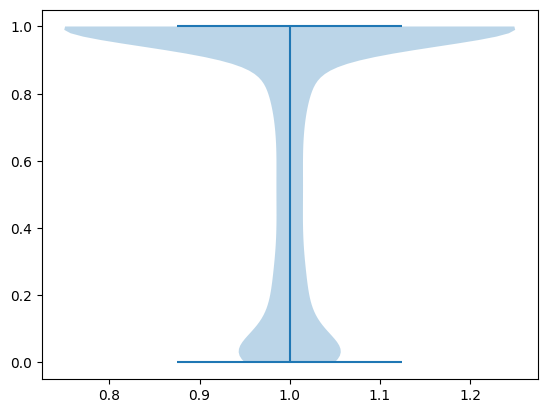

In [6]:
import matplotlib.pyplot as plt 
plt.violinplot(pred_amp)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f11e0450a60>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f11e0450880>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f11e0450940>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f11e0460220>}

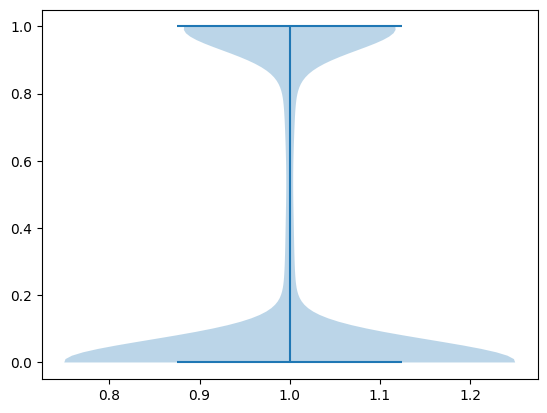

In [7]:
import matplotlib.pyplot as plt 
plt.violinplot(pred_mic)

In [17]:
print(pred_amp)
print(pred_mic)

[[0.99999905]]
[[0.11547378]]


In [8]:

mask2 = ((pred_amp >= 0.8) & (pred_mic < 0.5)).flatten()
mask3 = ((pred_amp >= 0.8) & (pred_mic >= 0.5)).flatten()

In [9]:
mask1 = (1 - (mask2 | mask3))
mask1 = [True if mask1[i] == 1 else False for i in range(len(mask1))]


In [10]:
data['sequence'].loc[mask1].to_csv('data/non_amp.csv', index=False, encoding='utf-8')   # non amp
data['sequence'].loc[mask2].to_csv('data/inactivate_amp.csv', index=False, encoding='utf-8')    # inactivate amp
data['sequence'].loc[mask3].to_csv('data/activate_amp.csv', index=False, encoding='utf-8')  # activate amp

# 读取抗菌肽数据并保存为csv文件

In [11]:
from Bio import SeqIO
filename = 'data/amps/APD_sequence_release_09142020.fasta'
iterator = SeqIO.parse(filename,'fasta')
write_file = open('data/APD_amp.csv', 'w')
writer = csv.writer(write_file)
writer.writerow(['sequence'])

for record in iter(iterator):
    if len(record.seq) <= 25:
        writer.writerow([record.seq])
write_file.close()

In [12]:
data = pd.read_csv('data/APD_amp.csv')
seq_list = data['sequence'].tolist()

In [13]:
amp_array = amp_classifier_model.predict(du_sequence.pad(du_sequence.to_one_hot(seq_list)))
mic_array = mic_classifier_model.predict(du_sequence.pad(du_sequence.to_one_hot(seq_list)))

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1251848c40>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f12518489d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1250057100>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1250057400>}

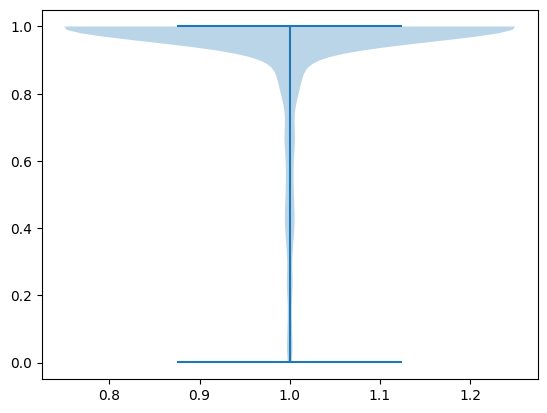

In [14]:
import matplotlib.pyplot as plt 
plt.violinplot(amp_array)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f125045d9d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f125045d7c0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f125045d820>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f125044e190>}

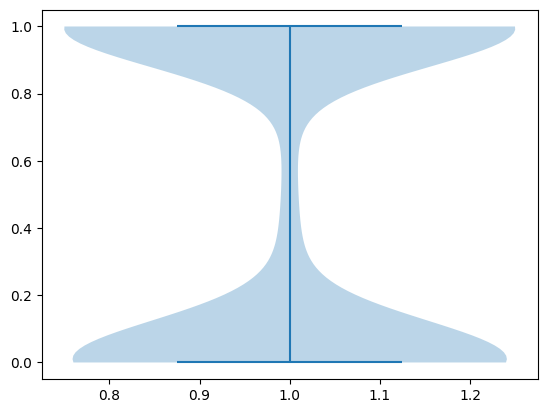

In [15]:
import matplotlib.pyplot as plt 
plt.violinplot(mic_array)

In [2]:
model_set = [
    'hydramp',
    'basic',
    'pepcvae'
]
for m in model_set:
    dic = {}
    w_f = open(f'result/{m}/result_best.csv','w')
    r_f = open(f'result/{m}/result_sortby_all.csv', 'r')
    reader = csv.reader(r_f)
    writer = csv.writer(w_f)
    writer.writerow([
        'description',
        'sequence', 
        'amp', 
        'mic', 
        'length', 
        'hydrophobicity',
        'hydrophobic_moment', 
        'charge', 
        'isoelectric_point'
    ])
    next(reader)
    for row in reader:
        dic[row[0]] = row
    for value in dic.values():
        writer.writerow(value)
    r_f.close()
    w_f.close()

In [12]:
data = pd.read_csv('data/APD_amp.csv').sequence.tolist()
all_data = pd.read_csv('data/train_all.csv').sequence.tolist()

In [13]:
sum = 0
for row in data:
    if row not in all_data:
        print(row)
        sum += 1
print(sum)

FLSLIPHAINAVSTLVHHS
GLWSKIKDVAAAAGKAALGAVNEAL
GLWSKIKDVAAAAGKAALGAVNEAL
FLPIVGKSLSGLSGKL
CKRWWKWIRW
FKLLSHSLLVTLASHLP
FLSMIPKIAGGIASLVKNL
AGFAAQAAASLAPVAVQQL
GFVALLKKLPLILKHLP
INLKAIAALAKKLF
FTVATFI
AIGHCLGATL
GLTRLFSVIK
GVVDILKGAAKDIAGHLASKVM
RSMRLSFRARGYGFR
AAGKGLVSNLLEK
GLVGTLLGHIGKAILGG
QSHLSLCRWCCNCCHNKGCGFCCKF
LSVKAFTGIQLRGVCGIEVKARG
FIVPSIFLLKKAFCIALKKC
ATCYCRTGR
ATCYCRTGRCATR
FLPILAGLAANLVPKLICSITKKC
GRTSKQELCTWERGSVRQADKTIAG
CLIMKVRRKK
SDTGTKSRK
26
